In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import Bounds
from scipy.optimize import minimize

In [2]:
QTD_ASSETS = 10
TAM_TRAIN = 60
QTD_PONTOS_FRONT = 400
PONTOS_FRONT = np.linspace(0, 1, QTD_PONTOS_FRONT)

In [3]:
bounds = Bounds(np.zeros(QTD_ASSETS), np.ones(QTD_ASSETS))

In [4]:
def retorno(QTD_ASSETS):
    df = pd.read_excel('ativos.xlsx', sheet_name='ATIVOS')
    df.set_index('Data', inplace=True)
    df = df[df.columns[:QTD_ASSETS]]
    df_ret = df.pct_change()
    df_ret = df_ret.dropna()
    return df_ret

retornos = retorno(QTD_ASSETS)

In [5]:
# b1    <= A * x   <==>   -b1 >= -A*x        <==>   A*x - b1 >= 0
# A * x <= b2      <==>    A*x - b2 <= 0     <==>  -Ax + b2 >= 0
A = np.ones(QTD_ASSETS)
b = np.array([1])

In [6]:
cons = [{"type": "ineq", "fun": lambda x: A @ x - b}, {"type": "ineq", "fun": lambda x: -A @ x + b}]

In [7]:
U0 = 1/QTD_ASSETS*np.ones(QTD_ASSETS)

In [8]:
def get_optimize(aux_ponto_front):
    
    def f(U,ponto_front = aux_ponto_front):
        retorno_treinamento=retornos[0:TAM_TRAIN-1]
        retorno_medio = retorno_treinamento.mean()
        retorno_carteira = retorno_medio.values.dot(U)
        risco_carteira = (U.dot(np.cov(retorno_treinamento.T))).dot(U)
        return ponto_front*risco_carteira-(1-ponto_front)*retorno_carteira

    Umin = minimize(f, U0, args=(),method='SLSQP',  jac=None, bounds=bounds, constraints=cons, 
                    tol=None,callback=None,options={'maxiter': 1000, 'ftol': 1e-16, 'iprint': 0,'eps': 1e-8})    
    return Umin.x

In [9]:
def get_retorno_risco(carteira):
    retorno_treinamento=retornos[0:TAM_TRAIN-1]
    retorno_medio = retorno_treinamento.mean()
    retorno_carteira = retorno_medio.values.dot(carteira)
    risco_carteira = (carteira.dot(np.cov(retorno_treinamento.T))).dot(carteira)
    return retorno_carteira, risco_carteira

In [10]:
def get_pareto_front():
    carteiras_front = []
    for ponto_front in PONTOS_FRONT:
        carteira = get_optimize(ponto_front)
        carteiras_front.append(carteira)
    retorno = np.zeros(QTD_PONTOS_FRONT)
    risco = np.zeros(QTD_PONTOS_FRONT)
    for i in range(QTD_PONTOS_FRONT):
        retorno[i], risco[i] = get_retorno_risco(carteiras_front[i])
    return retorno,risco    

In [11]:
retorno,risco = get_pareto_front()

No handles with labels found to put in legend.


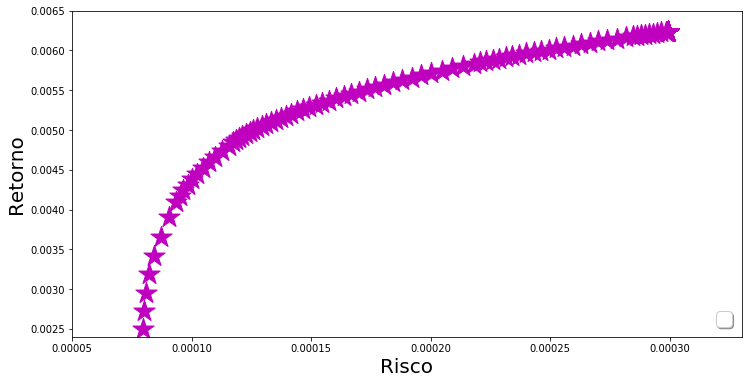

In [12]:
plt.figure(figsize = (12,6))
plt.scatter(risco,retorno,marker='*',s=500,c="m")
plt.xlabel('Risco', fontsize=20)
plt.ylabel('Retorno', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True, fontsize=20, ncol = 2)
plt.axis([0.00005, 0.00033, 0.0024, 0.0065]) # [xmin, xmax, ymin, ymax]
plt.show()